# HDG for Poisson problem
## Numerical experiments for the conditioning

Consider the Posson problem on $\Omega\subseteq\mathbb R^{d}$, $d=2,3$.

\begin{equation*}
\begin{array}{rclll}
-\Delta u &=& f&\mbox{in}&\Omega \\
u &=& u_D& \mbox{on}& \partial \Omega
\end{array}
\end{equation*}

In [63]:
from ngsolve import *
from netgen.geom2d import unit_square 
from ngsolve.webgui import Draw 
from ngsolve.la import EigenValues_Preconditioner
import scipy.sparse as sp
from scipy.sparse.linalg import eigs, eigsh
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [137]:
# Data
force2d = ((2*pi**2))*sin(pi*x)*sin(pi*y)
uD    = 0        
dirichlet_boundary2d='left|bottom|right|top'

In [138]:
# Fix h
h = 0.25
mesh2d = Mesh(unit_square.GenerateMesh(maxh=h))
# Draw(mesh)

In [141]:
def SetUp_HDG(mesh, p, db, condense=False):
    Vh = VectorL2(mesh, order=p)
    Wh = L2(mesh, order=p)
    Mh = FacetFESpace(mesh, order=p, dirichlet=dirichlet_boundary)
    fes = FESpace([Vh,Wh,Mh])
    qh, uh, uhat = fes.TrialFunction()
    vh, wh, what = fes.TestFunction()
    tau = 1.0 # stabilization parameter
    n = specialcf.normal(mesh.dim) # normal vector
    # HDG numerical flux
    qhatn = qh*n+tau*(uh-uhat)

    # Bilinear form
    a = BilinearForm(fes, condense=condense)
    a += (qh*vh - uh*div(vh))*dx +  (uhat*vh*n)*dx(element_boundary=True)
    a += (-div(qh)*wh*dx - tau*(uh-uhat)*wh*dx(element_boundary=True))
    a += qhatn*what*dx(element_boundary=True)
    a.Assemble()
    
    return a,  fes

def SolvePoisson_HDG(mesh, p, force, uD, db): # Dirichlet boundary conditions
    a, fes = SetUp_HDG(mesh, p, db, condense=False)
    # Right hand side
    f = LinearForm(fes)
    f += (-force)*wh*dx
    f.Assemble()
    
    gf = GridFunction(fes)
    gf.components[2].Set(uD, BND)
    r = f.vec.CreateVector()
    r.data = f.vec - a.mat * gf.vec
    inv = a.mat.Inverse(freedofs=fes.FreeDofs())
    gf.vec.data += inv * r
    return gf
    

In [142]:
gf = SolvePoisson_HDG(mesh2d, p=5,force=force2d, uD=uD, db=dirichlet_boundary2d)
Draw(gf.components[1])

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## Condition number

In [143]:
def get_kappa(mesh,p, db, condense):
    a, fes=SetUp_HDG(mesh, p, db, condense)
    # sparse scipy matrix
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    # restrict to freedof
    fd = list(fes.FreeDofs(condense))
    Afree = A[fd,:][:,fd]
    # Estimate condition number kappa
    lams_LM = eigsh(Afree, which='LM')[0]
    print(p,lams_LM)
    lams_SM = eigsh(Afree, which='SM')[0]
    print(p, lams_SM)
    lams = np.concatenate((np.abs(lams_LM), np.abs(lams_SM)))
    print(p, lams)
    kappa = max(lams)/min(lams)
    return kappa

In [144]:
def test_condition_number_fixmesh(mesh,db,condense=False, pmax=6):
    kappa=[]
    p = [i for i in range(2,pmax)]
    for pi in p:
        kappa.append(get_kappa(mesh, pi, db, condense))
    return p, kappa

In [145]:
# p, kappa= test_condition_number_fixmesh(mesh,dirichlet_boundary,condense=False, pmax=6)
p_sc, kappa_sc= test_condition_number_fixmesh(mesh2d,dirichlet_boundary2d,condense=True, pmax=15)


2 [-24.937 -24.355 -24.098 -22.994 -22.354 -21.328]
2 [-0.897 -0.843 -0.778 -0.661 -0.631 -0.325]
2 [24.937 24.355 24.098 22.994 22.354 21.328  0.897  0.843  0.778  0.661
  0.631  0.325]
3 [-31.97  -31.24  -30.83  -29.624 -28.903 -27.514]
3 [-0.902 -0.847 -0.782 -0.664 -0.634 -0.325]
3 [31.97  31.24  30.83  29.624 28.903 27.514  0.902  0.847  0.782  0.664
  0.634  0.325]
4 [-38.252 -37.448 -36.91  -35.261 -34.415 -32.875]
4 [-0.903 -0.847 -0.783 -0.664 -0.634 -0.326]
4 [38.252 37.448 36.91  35.261 34.415 32.875  0.903  0.847  0.783  0.664
  0.634  0.326]
5 [-44.968 -44.036 -43.303 -41.463 -40.46  -38.631]
5 [-0.903 -0.847 -0.783 -0.665 -0.634 -0.326]
5 [44.968 44.036 43.303 41.463 40.46  38.631  0.903  0.847  0.783  0.665
  0.634  0.326]
6 [-51.363 -50.344 -49.435 -47.248 -46.087 -44.075]
6 [-0.903 -0.847 -0.783 -0.665 -0.634 -0.326]
6 [51.363 50.344 49.435 47.248 46.087 44.075  0.903  0.847  0.783  0.665
  0.634  0.326]
7 [-57.979 -56.838 -55.73  -53.319 -51.959 -49.711]
7 [-0.903 -0.

In [146]:
# print(p, kappa)
print(p_sc, kappa_sc)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] [76.72704357189942, 98.23220270144854, 117.49998691294314, 138.1155182016836, 157.74910518258335, 178.0646867531559, 197.86949904960835, 218.0939018050072, 238.00921344180497, 258.20610358515285, 278.19825875752497, 298.390573695357, 318.43827177814296]


[76.72704357189942, 192.74647639340674, 306.90817428759766, 413.66235233281515, 512.6924936706237, 604.7043721248067, 690.5433921470948, 770.985905573627, 846.6987521191949, 918.2437168792441, 986.0925980916397, 1050.6429045546188, 1112.2315025497062]


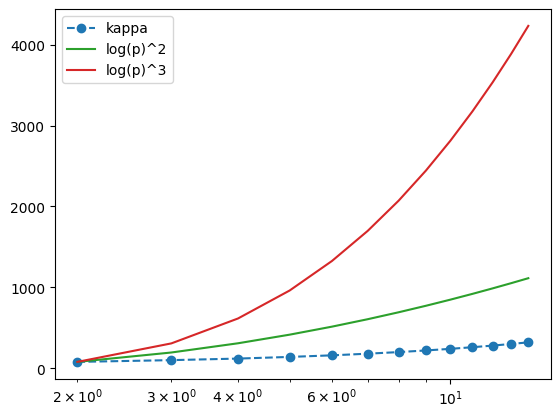

['-', 0.5364761481493363, 0.770054078534407, 1.083091489159337, 1.2385759392926032, 1.4678120072381218, 1.5889939400714077, 1.7663465643623522, 1.8656800639712106, 2.008157435083307, 2.092259825683032, 2.21013280403366, 2.2829499172543537]


In [154]:
import matplotlib.pyplot as plt

plt.semilogx(p_sc, kappa_sc,'--o',label='kappa')
C2 = kappa_sc[0]/(np.log(p_sc[0])*np.log(p_sc[0]))
p2 = [C2*np.log(p_i)*np.log(p_i) for p_i in p_sc]
print(p2)
plt.semilogx(p_sc, p2,'C02', label='log(p)^2')
C3 = kappa_sc[0]/(np.log(p_sc[0])*np.log(p_sc[0])*np.log(p_sc[0]))
p3 = [C3*np.log(p_i)*np.log(p_i)*np.log(p_i) for p_i in p_sc]
plt.semilogx(p_sc, p3,'C03', label='log(p)^3')
plt.legend()
plt.savefig('kappa_HDG_2d.png')
plt.show()
gamma2d = compute_gamma(kappa_sc, p_sc)
print(gamma2d)

# 3D problem

In [110]:
from netgen.csg import *

In [113]:
# Data
force = ((3*pi**2))*sin(pi*x)*sin(pi*y)*sin(pi*z)
uD    = 0        
dirichlet_boundary='back|left|front|right|bottom|top'

In [117]:
# Fix h
h = 0.5
mesh = Mesh(unit_cube.GenerateMesh(maxh=h))
# print(mesh.GetBoundaries())
# Draw(mesh)

In [119]:
gf = SolvePoisson_HDG(mesh, p=5,force=force, uD=uD, db=dirichlet_boundary)
# Draw(gf.components[1])

In [124]:
p_sc_3d, kappa_sc_3d= test_condition_number_fixmesh(mesh,dirichlet_boundary,condense=True, pmax=10)


2 [-16.543 -15.335 -12.995 -12.936 -12.62  -12.577]
2 [-0.057 -0.056 -0.054 -0.052 -0.049 -0.047]
2 [16.543 15.335 12.995 12.936 12.62  12.577  0.057  0.056  0.054  0.052
  0.049  0.047]
3 [-20.16  -18.967 -16.197 -16.044 -15.751 -15.681]
3 [-0.043 -0.041 -0.04  -0.039 -0.037 -0.035]
3 [20.16  18.967 16.197 16.044 15.751 15.681  0.043  0.041  0.04   0.039
  0.037  0.035]
4 [-24.477 -22.726 -19.384 -19.274 -18.879 -18.75 ]
4 [-0.035 -0.032 -0.031 -0.031 -0.029 -0.027]
4 [24.477 22.726 19.384 19.274 18.879 18.75   0.035  0.032  0.031  0.031
  0.029  0.027]
5 [-27.908 -26.081 -22.319 -22.094 -21.818 -21.556]
5 [-0.029 -0.026 -0.026 -0.025 -0.023 -0.022]
5 [2.791e+01 2.608e+01 2.232e+01 2.209e+01 2.182e+01 2.156e+01 2.904e-02
 2.569e-02 2.553e-02 2.487e-02 2.317e-02 2.158e-02]
6 [-31.955 -29.644 -25.311 -25.117 -24.783 -24.405]
6 [-0.025 -0.022 -0.021 -0.021 -0.019 -0.018]
6 [3.196e+01 2.964e+01 2.531e+01 2.512e+01 2.478e+01 2.441e+01 2.467e-02
 2.157e-02 2.144e-02 2.085e-02 1.941e-02 1.80

[355.66518537803654, 893.4686919506348, 1422.6607415121462, 1917.5155248683225, 2376.565840601124, 2803.0832754443154, 3200.986668402328, 3573.8747678025393] [355.6651853780365, 580.8679540016701, 915.3064255607039, 1293.2292726987116, 1770.9662326746802, 2285.9340562307134, 2899.1560515232845, 3551.724971415128]


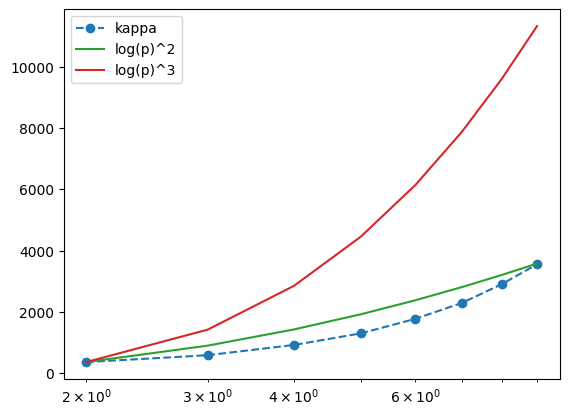

In [127]:
import matplotlib.pyplot as plt

plt.semilogx(p_sc_3d, kappa_sc_3d,'--o',label='kappa')

C2 = kappa_sc_3d[0]/(np.log(p_sc_3d[0])*np.log(p_sc_3d[0]))
p2 = [C2*np.log(p_i)*np.log(p_i) for p_i in p_sc_3d]
print(p2, kappa_sc_3d)
plt.semilogx(p_sc_3d, p2,'C02', label='log(p)^2')

C3 = kappa_sc_3d[0]/(np.log(p_sc_3d[0])*np.log(p_sc_3d[0])*np.log(p_sc_3d[0]))
p3 = [C3*np.log(p_i)*np.log(p_i)*np.log(p_i) for p_i in p_sc_3d]
plt.semilogx(p_sc_3d, p3,'C03', label='log(p)^3')
plt.legend()
plt.savefig('kappa_HDG_3d.png')
plt.show()

In [152]:
def compute_gamma(kappa, p):
    gamma = ['-']
    for i in range(len(p)-1):
        gamma.append(np.log(kappa[i+1]/kappa[i])/np.log(np.log(p[i+1])/np.log(p[i])))
    return gamma
gamma3d = compute_gamma(kappa_sc_3d, p_sc_3d)
print(gamma3d)

['-', 1.065079170282748, 1.955124546861162, 2.315826318146276, 2.9295857815955797, 3.092742960667678, 3.5806319746844757, 3.684751001319045]


In [153]:
gamma2d = compute_gamma(kappa_sc, p_sc)
print(gamma2d)

['-', 0.5364761481493363, 0.770054078534407, 1.083091489159337, 1.2385759392926032, 1.4678120072381218, 1.5889939400714077, 1.7663465643623522, 1.8656800639712106, 2.008157435083307, 2.092259825683032, 2.21013280403366, 2.2829499172543537]


# Tables

In [157]:
import pandas as pd

df_2d = pd.DataFrame({'p':p_sc, 'kappa':kappa_sc, 'log(p)':np.log(p_sc), 'gamma':gamma2d})
df_2d

,p,kappa,log(p),gamma
0,2,76.727044,0.693147,-
1,3,98.232203,1.098612,0.536476
2,4,117.499987,1.386294,0.770054
3,5,138.115518,1.609438,1.083091
4,6,157.749105,1.791759,1.238576
5,7,178.064687,1.945910,1.467812
6,8,197.869499,2.079442,1.588994
7,9,218.093902,2.197225,1.766347
8,10,238.009213,2.302585,1.86568
9,11,258.206104,2.397895,2.008157


In [158]:
df_3d = pd.DataFrame({'p':p_sc_3d, 'kappa':kappa_sc_3d, 'log(p)':np.log(p_sc_3d), 'gamma':gamma3d})
df_3d

,p,kappa,log(p),gamma
0,2,355.665185,0.693147,-
1,3,580.867954,1.098612,1.065079
2,4,915.306426,1.386294,1.955125
3,5,1293.229273,1.609438,2.315826
4,6,1770.966233,1.791759,2.929586
5,7,2285.934056,1.945910,3.092743
6,8,2899.156052,2.079442,3.580632
7,9,3551.724971,2.197225,3.684751
